# Prediction with Model

### Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.image as mpimg
from collections import Counter
from six.moves import cPickle as pickle
from scipy import ndimage
import tensorflow as tf
import copy
from sklearn.utils import shuffle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

print('Modules loaded.')

Modules loaded.


### Load the data

In [2]:
filename = './test_data'
with open(filename + '.pickle', 'rb') as f:
    test_data = pickle.load(f)
X_test_full = test_data['X_test']
y_test_full = test_data['y_test']
image_path_test_full = test_data['image_path_test']

In [3]:
print(X_test_full.shape)
print(y_test_full.shape)
print(len(image_path_test_full))

(13068, 32, 32, 1)
(13068, 26)
13068


### Preprocess the data

In [4]:
# extract digit length and digit label for 5 digit positions
# element 0 is digit length
# element 1 to 5 are digit labels
y_test_digit = copy.deepcopy(y_test_full[:,0:6])

# the length labels of the data are of range (1,5)
# convert this to become of range (0,4) for ease of sparse softmax entropy computation
y_test_digit[:,0] = y_test_digit[:,0] - 1

# extract bounding box targets - 20 values in total
# element 6 to 10 are bbox top coordinates for 5 digit positions
# element 11 to 15 are bbox left coordinates for 5 digit positions
# element 16 to 20 are bbox width for 5 digit positions
# element 21 to 25 are bbox height for 5 digit positions
y_test_bbox = copy.deepcopy(y_test_full[:,6:])

In [5]:
# Use full test dataset
X_test = X_test_full
y_digit_test = y_test_digit
y_bbox_test = y_test_bbox

print('Test sample size:: %s, %s, %s'%(X_test.shape, y_digit_test.shape, y_bbox_test.shape))

Test sample size:: (13068, 32, 32, 1), (13068, 6), (13068, 20)


In [6]:
# Convert feature data to type float32 
X_test = X_test.astype(np.float32)

# Convert classification class labels to type float32 
y_digit_test = y_digit_test.astype(np.int32)

# Convert regression targets to type float32
y_bbox_test = y_bbox_test.astype(np.float32)

### Add noise to test images

In [7]:
def gaussian_noise(image, sd_factor):
    return image + sd_factor*image.std()*np.random.random(image.shape)

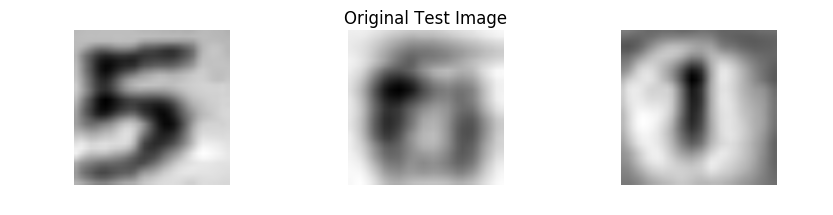

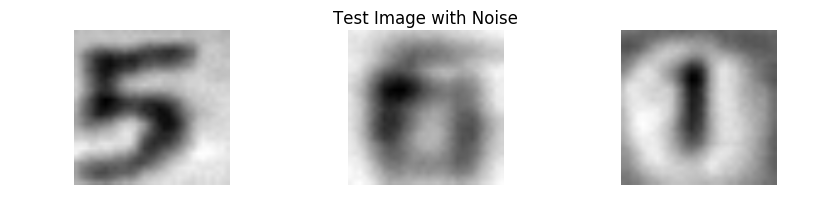

In [8]:
fig = plt.figure(figsize=(10, 2))
plt.axis("off")
plt.title("Original Test Image")
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.axis("off")
    plt.imshow(X_test[i,:,:,0],cmap="gray")
plt.show()

X_test_noise = copy.deepcopy(X_test)
noise_factor = 0.2
for i in range(X_test.shape[0]):
    X_test_noise[i,:,:,0] = gaussian_noise(X_test_noise[i,:,:,0],noise_factor)

fig = plt.figure(figsize=(10, 2))
plt.title("Test Image with Noise")
plt.axis("off")
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.axis("off")
    plt.imshow(X_test_noise[i,:,:,0],cmap="gray")
plt.show()

In [9]:
X_test = X_test_noise

### Defining the graph

In [10]:
def accuracy_length(predictions, labels):
    """ Compute length accuracy.
    Args:
        predictions:    (numpy array) predicted values [length,digit1,digit2,digit3,digit4,digit5].
        labels:         (numpy array) actual values [length,digit1,digit2,digit3,digit4,digit5].
    Returns:
        (float) Full sequence accuracy in percentage.
    """
    return (100.0 * np.sum(np.equal(predictions[:,0],labels[:,0])) / predictions.shape[0])

In [11]:
def accuracy_full_sequence(predictions, labels):
    """ Compute full sequence accuracy.
    Args:
        predictions:    (numpy array) predicted values [length,digit1,digit2,digit3,digit4,digit5].
        labels:         (numpy array) actual values [length,digit1,digit2,digit3,digit4,digit5].
    Returns:
        (float) Full sequence accuracy in percentage.
    """
    return (100.0 * np.sum(np.sum(np.equal(predictions[:,1:],labels[:,1:]), axis=1)==num_digits) / predictions.shape[0])

In [12]:
def batch_iou(a, b, epsilon=1e-5):
    """ Given two arrays `a` and `b` where each row contains a bounding
        box defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union scores for each corresponding
        pair of boxes.
    Args:
        a:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        b:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        epsilon:    (float) Small value to prevent division by zero
    Returns:
        (numpy array) The Intersect of Union scores for each pair of bounding boxes.
    
    Credit: Ronny Restrepo (https://github.com/ronrest/real_time_multi_digit_recognition/blob/master/evals.py)
    
    """
    # COORDINATES OF THE INTERSECTION BOXES
    x1 = np.array([a[:, 0], b[:, 0]]).max(axis=0)
    y1 = np.array([a[:, 1], b[:, 1]]).max(axis=0)
    x2 = np.array([a[:, 2], b[:, 2]]).min(axis=0)
    y2 = np.array([a[:, 3], b[:, 3]]).min(axis=0)
    
    # AREAS OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    
    # handle case where there is NO overlap
    width[width < 0] = 0
    height[height < 0] = 0
    
    area_overlap = width * height
    
    # COMBINED AREAS
    area_a = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    area_b = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    area_combined = area_a + area_b - area_overlap
    
    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined + epsilon)
    return iou

In [13]:
def batch_multi_column_iou(predictions, targets, epsilon=1e-5):
    """ Compute average Intersection over Union for a batch of predictions with multiple bounding boxes.
        
        The average is calculated on the basis of available
        bounding boxes in the targets data 
    Args:
        predictions:(numpy array) predicted values [length,top1,...,top5,left1,...,left5,width1,...,width5,height1,...,height5]
        targets:    (numpy array) target values [length,top1,...,top5,left1,...,left5,width1,...,width5,height1,...,height5]
        epsilon:    (float) Small value to prevent division by zero
    Returns:
        (float) Average of IoU over available bounding boxes in the batch, in percentage.
    """
    # Extract upper left and lower right coordinated of predicted bbox
    a_top=predictions[:,1:6]
    a_left=predictions[:,6:11]
    a_width=predictions[:,11:16]
    a_height=predictions[:,16:21]
    a_right = a_left+a_width-1
    a_bottom = a_top+a_height-1
    
    # Extract number of bbox according to target data
    b_length=targets[:,0]
    # Extract upper left and lower right coordinated of target bbox
    b_top=targets[:,1:6]
    b_left=targets[:,6:11]
    b_width=targets[:,11:16]
    b_height=targets[:,16:21]
    b_right = b_left+b_width-1
    b_bottom = b_top+b_height-1
    
    n_bboxes = 5
    n_samples = predictions.shape[0]
    ious = np.zeros([1],dtype=np.float32)
       
    # concatenate IoU value of all available bbox
    for i in range(n_samples):
        for j in range(int(b_length[i])):
            a_l = np.reshape(a_left[i,j],[-1,1])
            a_t = np.reshape(a_top[i,j],[-1,1])
            a_r = np.reshape(a_right[i,j],[-1,1])
            a_b = np.reshape(a_bottom[i,j],[-1,1])

            b_l = np.reshape(b_left[i,j],[-1,1])
            b_t = np.reshape(b_top[i,j],[-1,1])
            b_r = np.reshape(b_right[i,j],[-1,1])
            b_b = np.reshape(b_bottom[i,j],[-1,1])
        
            iou = batch_iou(np.concatenate((a_l,a_t,a_r,a_b),axis=1),
                            np.concatenate((b_l,b_t,b_r,b_b),axis=1),
                            epsilon)
            ious = np.concatenate((ious,iou),axis=0)
    
    return np.mean(ious[1:],axis=0)*100.

In [14]:
def he_weights_initializer(dtype=tf.float32):
    """ Initialize weights by random sampling from normal distribution of mean 0 and 
        standard deviation sqrt(2./fan_in).
        
        where fan_in is number of inputs. For convolutional layer, it's equal to patch_size*patch_size*input_depth.
        For fully connected layer, it's equal to number of input nodes.
        
        Values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked.
    Returns:
        (method) _initializer
    
    Reference: He, et al. (2015) - Delving Deep into Rectifiers: Surpassing Human-Level Performance on 
               ImageNet Classification (https://arxiv.org/abs/1502.01852)
    """
    def _initializer(shape, dtype=dtype, partition_info=None):
        shape = list(shape)
        if (len(shape)==4):
            receptive_field_size = np.prod(shape[:2])
            fan_in = shape[-2] * receptive_field_size
        elif (len(shape)==2):
            fan_in = shape[0]
        sd = np.sqrt(2. / fan_in)
        return tf.truncated_normal(shape, stddev=sd, dtype=dtype)
    return _initializer

In [15]:
def batch_norm_relu(x, is_training, iteration, beta, conv=False):
    """ Batch normalization for ReLu 
    
        Normalize the input, x based on its batch mean and variance plus some offset, beta during training.
        During prediction, moving average of the mean and variance will be used instead of batch mean and variance.
    
    Args:
        x:              (tf.variables) input.   
        is_training:    (tf.bool) boolean flag to indicate whether it is in training mode.
        beta:           (tf.float) trainable offset parameter to the normalized result.
        conv:           (tf.bool) boolean flag to indicate whether the input is convolutional layer or fully connected layer.
    Returns:
        (tf.variables) Ybn - the batch normalized output.
        update_moving_averages - A Tensorflow operation that updates the moving averages.
    
    Credit: Martin Gorner 
            (https://github.com/martin-gorner/tensorflow-mnist-tutorial/blob/master/mnist_4.2_batchnorm_convolutional.py)
    Reference: Ioffe, Szegedy (2015) - Batch Normalization: Accelerating Deep Network Training by Reducing Internal 
               Covariate Shift (https://arxiv.org/abs/1502.03167)
    """
    
    # adding the iteration prevents from averaging across non-existing iterations
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.9999, iteration)
    bnepsilon = 1e-5
    
    # calculate mean and variance for batch of logits
    if conv:
        mean, variance = tf.nn.moments(x, [0, 1, 2])
    else:
        # mean and variance along the batch
        mean, variance = tf.nn.moments(x, [0])
    
    update_moving_averages = exp_moving_avg.apply([mean, variance])
    
    # Mean and Variance (how it get it is dependent on whether it is training)
    m = tf.cond(is_training,
                lambda: mean,
                lambda: exp_moving_avg.average(mean))
    v = tf.cond(is_training,
                lambda: variance,
                lambda: exp_moving_avg.average(variance))
    
    # Apply Batch Norm
    Ybn = tf.nn.batch_normalization(x, m, v, offset=beta, scale=None,
                                    variance_epsilon=bnepsilon)
    return Ybn, update_moving_averages

In [16]:
num_labels = 11 #'A'-'J', and blank character 
num_digits = 5
num_logit = 6
num_bbox = num_digits*4

image_size = 32
num_channels = 1
batch_size = 64
patch_size1 = 5
depth1 = 40
patch_size2 = 5
depth2 = 80
patch_size3 = 5
depth3 = 80
patch_size4 = 5
depth4 = 160
patch_size5 = 3
depth5 = 160
patch_size6 = 3
depth6 = 480
patch_size7 = 3
depth7 = 720

num_hidden_digit = 3000
num_hidden_bbox = 3000

keep_prob_conv_train = 0.70
keep_prob_fc_digit_train = 0.20
keep_prob_fc_bbox_train = 0.20

learning_rate_constant = 0.0001

In [17]:
graph = tf.Graph()

with graph.as_default():
    
    # Input data.
    tf_dataset = tf.placeholder(tf.float32, [None, image_size, image_size, num_channels])
    tf_labels = tf.placeholder(tf.int32, [None, num_logit])
    tf_bbox_targets = tf.placeholder(tf.float32, [None, num_bbox])
    
    # Parameter placeholder.
    iteration = tf.placeholder(tf.int32)
    training_flag = tf.placeholder(tf.bool)
    keep_prob_conv = tf.placeholder(tf.float32)
    keep_prob_fc_digit = tf.placeholder(tf.float32)
    keep_prob_fc_bbox = tf.placeholder(tf.float32)

    # Variables. 
    global_step = tf.Variable(0, trainable=False)
    
    W1 = tf.get_variable("W1", shape=[patch_size1, patch_size1, num_channels, depth1],
                                     initializer=he_weights_initializer())
    B1 = tf.Variable(tf.constant(1.0, tf.float32, [depth1]),name="B1")
    W2 = tf.get_variable("W2", shape=[patch_size2, patch_size2, depth1, depth2],
                                     initializer=he_weights_initializer())
    B2 = tf.Variable(tf.constant(1.0, tf.float32, [depth2]),name="B2")
    W3 = tf.get_variable("W3", shape=[patch_size3, patch_size3, depth2, depth3],
                                     initializer=he_weights_initializer())
    B3 = tf.Variable(tf.constant(1.0, tf.float32, [depth3]),name="B3")
    W4 = tf.get_variable("W4", shape=[patch_size4, patch_size4, depth3, depth4],
                                     initializer=he_weights_initializer())
    B4 = tf.Variable(tf.constant(1.0, tf.float32, [depth4]),name="B4")
    W5 = tf.get_variable("W5", shape=[patch_size5, patch_size5, depth4, depth5],
                                     initializer=he_weights_initializer())
    B5 = tf.Variable(tf.constant(1.0, tf.float32, [depth5]),name="B5")
    W6 = tf.get_variable("W6", shape=[patch_size6, patch_size6, depth5, depth6],
                                     initializer=he_weights_initializer())
    B6 = tf.Variable(tf.constant(1.0, tf.float32, [depth6]),name="B6")
    W7 = tf.get_variable("W7", shape=[patch_size7, patch_size7, depth6, depth7],
                                     initializer=he_weights_initializer())
    B7 = tf.Variable(tf.constant(1.0, tf.float32, [depth7]),name="B7")
    
    flatten_length = 2*2*depth7
    
    W8_0 = tf.get_variable("W8_0", shape=[flatten_length, num_hidden_digit],
                                      initializer=he_weights_initializer())
    B8_0 = tf.Variable(tf.constant(1.0, tf.float32, [num_hidden_digit]),name="B8_0")
    
    W8_1 = tf.get_variable("W8_1", shape=[flatten_length, num_hidden_bbox],
                                      initializer=he_weights_initializer())
    B8_1 = tf.Variable(tf.constant(1.0, tf.float32, [num_hidden_bbox]),name="B8_1")
    
    W9_0 = tf.get_variable("W9_0", shape=[num_hidden_digit, num_digits],
                                      initializer=he_weights_initializer())
    B9_0 = tf.Variable(tf.constant(1.0, tf.float32, [num_digits]),name="B9_0")
    W9_1 = tf.get_variable("W9_1", shape=[num_hidden_digit, num_labels],
                                      initializer=he_weights_initializer())
    B9_1 = tf.Variable(tf.constant(1.0, tf.float32, [num_labels]),name="B9_1")
    W9_2 = tf.get_variable("W9_2", shape=[num_hidden_digit, num_labels],
                                      initializer=he_weights_initializer())
    B9_2 = tf.Variable(tf.constant(1.0, tf.float32, [num_labels]),name="B9_2")
    W9_3 = tf.get_variable("W9_3", shape=[num_hidden_digit, num_labels],
                                      initializer=he_weights_initializer())
    B9_3 = tf.Variable(tf.constant(1.0, tf.float32, [num_labels]),name="B9_3")
    W9_4 = tf.get_variable("W9_4", shape=[num_hidden_digit, num_labels],
                                      initializer=he_weights_initializer())
    B9_4 = tf.Variable(tf.constant(1.0, tf.float32, [num_labels]),name="B9_4")
    W9_5 = tf.get_variable("W9_5", shape=[num_hidden_digit, num_labels],
                                      initializer=he_weights_initializer())
    B9_5 = tf.Variable(tf.constant(1.0, tf.float32, [num_labels]),name="B9_5")
    W9_6 = tf.get_variable("W9_6", shape=[num_hidden_bbox, num_bbox],
                                      initializer=he_weights_initializer())
    B9_6 = tf.Variable(tf.constant(1.0, tf.float32, [num_bbox]),name="B9_6")
    
    def model(data, 
              keep_prob_conv, 
              keep_prob_fc_digit, 
              keep_prob_fc_bbox, 
              iteration, 
              is_training):
        conv1 = tf.nn.conv2d(data,W1, [1,1,1,1],padding='SAME', name='C1') 
        act1 = tf.nn.relu(conv1)
        batch_norm1, update_ema1 = batch_norm_relu(act1, is_training, iteration, B1, conv=True)
        sub1 = tf.nn.max_pool(batch_norm1, [1,2,2,1], [1,2,2,1], 'SAME', name='S1')
        drop1 = tf.nn.dropout(sub1, keep_prob_conv)
        
        conv2 = tf.nn.conv2d(drop1, W2, [1,1,1,1], padding='SAME', name='C2') 
        act2 = tf.nn.relu(conv2)
        batch_norm2, update_ema2 = batch_norm_relu(act2, is_training, iteration, B2, conv=True)
        drop2 = tf.nn.dropout(batch_norm2, keep_prob_conv)
        
        conv3 = tf.nn.conv2d(drop2, W3, [1,1,1,1], padding='SAME', name='C3') 
        act3 = tf.nn.relu(conv3)
        batch_norm3, update_ema3 = batch_norm_relu(act3, is_training, iteration, B3, conv=True)
        sub3 = tf.nn.max_pool(batch_norm3, [1,2,2,1], [1,2,2,1], 'SAME', name='S3')  
        drop3 = tf.nn.dropout(sub3, keep_prob_conv)
        
        conv4 = tf.nn.conv2d(drop3, W4, [1,1,1,1], padding='SAME', name='C4') 
        act4 = tf.nn.relu(conv4)
        batch_norm4, update_ema4 = batch_norm_relu(act4, is_training, iteration, B4, conv=True) 
        drop4 = tf.nn.dropout(batch_norm4, keep_prob_conv)
        
        conv5 = tf.nn.conv2d(drop4, W5, [1,1,1,1], padding='SAME', name='C5') 
        act5 = tf.nn.relu(conv5)
        batch_norm5, update_ema5 = batch_norm_relu(act5, is_training, iteration, B5, conv=True)
        sub5 = tf.nn.max_pool(batch_norm5, [1,2,2,1], [1,2,2,1], 'SAME', name='S5')  
        drop5 = tf.nn.dropout(sub5, keep_prob_conv)
        
        conv6 = tf.nn.conv2d(drop5, W6, [1,1,1,1], padding='SAME', name='C6') 
        act6 = tf.nn.relu(conv6)
        batch_norm6, update_ema6 = batch_norm_relu(act6, is_training, iteration, B6, conv=True) 
        drop6 = tf.nn.dropout(batch_norm6, keep_prob_conv)
        
        conv7 = tf.nn.conv2d(drop6, W7, [1,1,1,1], padding='SAME', name='C7') 
        act7 = tf.nn.relu(conv7)
        batch_norm7, update_ema7 = batch_norm_relu(act7, is_training, iteration, B7, conv=True) 
        sub7 = tf.nn.max_pool(batch_norm7, [1,2,2,1], [1,2,2,1], 'SAME', name='S7')  
        drop7 = tf.nn.dropout(sub7, keep_prob_conv)
        
        # flatten
        shape7 = drop7.get_shape().as_list()
        flatten7 = tf.reshape(drop7, [-1, shape7[1] * shape7[2] * shape7[3]])
        
        z8_0 = tf.matmul(flatten7, W8_0) 
        act8_0 = tf.nn.relu(z8_0)
        batch_norm8_0, update_ema8_0 = batch_norm_relu(act8_0, is_training, iteration, B8_0, conv=False)
        shape8_0 = batch_norm8_0.get_shape().as_list()
        reshape8_0 = tf.reshape(batch_norm8_0, [-1, shape8_0[1], 1, 1])
        drop8_0 = tf.nn.dropout(reshape8_0, keep_prob_fc_digit)        
        hidden8_0 = tf.reshape(drop8_0, [-1, shape8_0[1]])
        
        z8_1 = tf.matmul(flatten7, W8_1) 
        act8_1 = tf.nn.relu(z8_1)
        batch_norm8_1, update_ema8_1 = batch_norm_relu(act8_1, is_training, iteration, B8_1, conv=False)
        shape8_1 = batch_norm8_1.get_shape().as_list()
        reshape8_1 = tf.reshape(batch_norm8_1, [-1, shape8_1[1], 1, 1])
        drop8_1 = tf.nn.dropout(reshape8_1, keep_prob_fc_bbox)        
        hidden8_1 = tf.reshape(drop8_1, [-1, shape8_1[1]])
        
        logits0 = tf.matmul(hidden8_0, W9_0) + B9_0
        logits1 = tf.matmul(hidden8_0, W9_1) + B9_1
        logits2 = tf.matmul(hidden8_0, W9_2) + B9_2
        logits3 = tf.matmul(hidden8_0, W9_3) + B9_3
        logits4 = tf.matmul(hidden8_0, W9_4) + B9_4
        logits5 = tf.matmul(hidden8_0, W9_5) + B9_5
        bbox_logits = tf.matmul(hidden8_1, W9_6) + B9_6
        
        update_ema = tf.group(update_ema1, update_ema2, update_ema3, update_ema4, 
                              update_ema5, update_ema6, update_ema7, update_ema8_0, 
                              update_ema8_1)
        
        return [logits0, logits1, logits2, logits3, logits4, logits5, bbox_logits, update_ema]
  
    # Training computation.
    [logits0, logits1, logits2, logits3, logits4, logits5, bbox_logits, update_ema] = model(tf_dataset, 
                                                                                            keep_prob_conv, 
                                                                                            keep_prob_fc_digit,
                                                                                            keep_prob_fc_bbox,
                                                                                            iteration,
                                                                                            is_training=training_flag)
    length = tf.argmax(tf.nn.softmax(logits0), 1)
    char1 = tf.select(tf.greater_equal(length, 0*tf.ones_like(length)),
                    tf.argmax(tf.nn.softmax(logits1), 1),
                    10*tf.ones_like(length))
    char2 = tf.select(tf.greater_equal(length, 1*tf.ones_like(length)),
                    tf.argmax(tf.nn.softmax(logits2), 1),
                    10*tf.ones_like(length))
    char3 = tf.select(tf.greater_equal(length, 2*tf.ones_like(length)),
                    tf.argmax(tf.nn.softmax(logits3), 1),
                    10*tf.ones_like(length))
    char4 = tf.select(tf.greater_equal(length, 3*tf.ones_like(length)),
                    tf.argmax(tf.nn.softmax(logits4), 1),
                    10*tf.ones_like(length))
    char5 = tf.select(tf.greater_equal(length, 4*tf.ones_like(length)),
                    tf.argmax(tf.nn.softmax(logits5), 1),
                    10*tf.ones_like(length))
    
    loss0 = tf.nn.sparse_softmax_cross_entropy_with_logits(logits0, tf_labels[:,0])
    loss_digit_1 = tf.select(tf.greater_equal(tf_labels[:,0], 0*tf.ones_like(length,dtype=tf.int32)),
                      tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_labels[:,1]),
                      tf.zeros_like(length,dtype=tf.float32))
    loss_digit_2 = tf.select(tf.greater_equal(tf_labels[:,0], 1*tf.ones_like(length,dtype=tf.int32)),
                      tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_labels[:,2]),
                      tf.zeros_like(length,dtype=tf.float32))
    loss_digit_3 = tf.select(tf.greater_equal(tf_labels[:,0], 2*tf.ones_like(length,dtype=tf.int32)),
                      tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_labels[:,3]),
                      tf.zeros_like(length,dtype=tf.float32))
    loss_digit_4 = tf.select(tf.greater_equal(tf_labels[:,0], 3*tf.ones_like(length,dtype=tf.int32)),
                      tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_labels[:,4]),
                      tf.zeros_like(length,dtype=tf.float32))
    loss_digit_5 = tf.select(tf.greater_equal(tf_labels[:,0], 4*tf.ones_like(length,dtype=tf.int32)),
                      tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_labels[:,5]),
                      tf.zeros_like(length,dtype=tf.float32))
    losses_digit = tf.pack([loss_digit_1, loss_digit_2, loss_digit_3, loss_digit_4, loss_digit_5],axis=1)
    
    bbox_digit_1 = tf.pack([bbox_logits[:,0],bbox_logits[:,5],bbox_logits[:,10],bbox_logits[:,15]],axis=1)
    bbox_digit_2 = tf.pack([bbox_logits[:,1],bbox_logits[:,6],bbox_logits[:,11],bbox_logits[:,16]],axis=1)
    bbox_digit_3 = tf.pack([bbox_logits[:,2],bbox_logits[:,7],bbox_logits[:,12],bbox_logits[:,17]],axis=1)
    bbox_digit_4 = tf.pack([bbox_logits[:,3],bbox_logits[:,8],bbox_logits[:,13],bbox_logits[:,18]],axis=1)
    bbox_digit_5 = tf.pack([bbox_logits[:,4],bbox_logits[:,9],bbox_logits[:,14],bbox_logits[:,19]],axis=1)
    
    bbox_target_1 = tf.pack([tf_bbox_targets[:,0],tf_bbox_targets[:,5],tf_bbox_targets[:,10],tf_bbox_targets[:,15]],
                            axis=1)
    bbox_target_2 = tf.pack([tf_bbox_targets[:,1],tf_bbox_targets[:,6],tf_bbox_targets[:,11],tf_bbox_targets[:,16]],
                            axis=1)
    bbox_target_3 = tf.pack([tf_bbox_targets[:,2],tf_bbox_targets[:,7],tf_bbox_targets[:,12],tf_bbox_targets[:,17]],
                            axis=1)
    bbox_target_4 = tf.pack([tf_bbox_targets[:,3],tf_bbox_targets[:,8],tf_bbox_targets[:,13],tf_bbox_targets[:,18]],
                            axis=1)
    bbox_target_5 = tf.pack([tf_bbox_targets[:,4],tf_bbox_targets[:,9],tf_bbox_targets[:,14],tf_bbox_targets[:,19]],
                            axis=1)
    
    loss_bbox_1 = tf.select(tf.greater_equal(tf_labels[:,0], 0*tf.ones_like(length,dtype=tf.int32)),
                            tf.reduce_sum(tf.square(bbox_digit_1-bbox_target_1),1),
                            tf.zeros_like(length,dtype=tf.float32))
    loss_bbox_2 = tf.select(tf.greater_equal(tf_labels[:,0], 1*tf.ones_like(length,dtype=tf.int32)),
                            tf.reduce_sum(tf.square(bbox_digit_2-bbox_target_2),1),
                            tf.zeros_like(length,dtype=tf.float32))
    loss_bbox_3 = tf.select(tf.greater_equal(tf_labels[:,0], 2*tf.ones_like(length,dtype=tf.int32)),
                            tf.reduce_sum(tf.square(bbox_digit_3-bbox_target_3),1),
                            tf.zeros_like(length,dtype=tf.float32))
    loss_bbox_4 = tf.select(tf.greater_equal(tf_labels[:,0], 3*tf.ones_like(length,dtype=tf.int32)),
                            tf.reduce_sum(tf.square(bbox_digit_4-bbox_target_4),1),
                            tf.zeros_like(length,dtype=tf.float32))
    loss_bbox_5 = tf.select(tf.greater_equal(tf_labels[:,0], 4*tf.ones_like(length,dtype=tf.int32)),
                            tf.reduce_sum(tf.square(bbox_digit_5-bbox_target_5),1),
                            tf.zeros_like(length,dtype=tf.float32))
    losses_bbox = tf.pack([loss_bbox_1, loss_bbox_2, loss_bbox_3, loss_bbox_4, loss_bbox_5],axis=1)
    
    # Define loss function
    loss_length = tf.reduce_mean(loss0,0)
    
    loss_digit = tf.reduce_mean(tf.reduce_sum(losses_digit,1),0)
    
    loss_bbox=tf.sqrt(tf.reduce_mean(tf.reduce_sum(losses_bbox,1),0))
    
    loss = loss_length + loss_digit + loss_bbox
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_constant, beta1=0.9, beta2=0.999,
                                       epsilon=1e-08).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    predictions = tf.pack([length,char1,char2,char3,char4,char5],axis=1)
    predictions_bbox = tf.concat(1,[tf.reshape(tf.to_float(length),(-1,1)),bbox_logits])
    
    saver = tf.train.Saver()

### Making predictions

In [18]:
def predict(checkpoint):
    with tf.Session(graph=graph) as session:
        saver.restore(session, checkpoint)
        test_num_steps = X_test.shape[0]/batch_size
        offset = 0
        predictions_test_full = np.zeros((1,num_logit))
        predictions_test_bbox_full = np.zeros((1,num_bbox+1))
        for step in range(test_num_steps):
            batch_data = X_test[offset:(offset + batch_size), :, :, :]
            batch_labels = y_digit_test[offset:(offset + batch_size),:]
            batch_bbox_targets = y_bbox_test[offset:(offset + batch_size),:]
            offset += batch_size
            feed_dict = {tf_dataset : batch_data, 
                         tf_labels : batch_labels, 
                         tf_bbox_targets: batch_bbox_targets,
                         training_flag: False, 
                         keep_prob_conv : 1.00, 
                         keep_prob_fc_digit : 1.00,
                         keep_prob_fc_bbox : 1.00, 
                         iteration : step}
            predictions_test, predictions_bbox_test = session.run([predictions,predictions_bbox], feed_dict=feed_dict)
            predictions_test_full = np.concatenate((predictions_test_full, predictions_test), axis = 0)
            predictions_test_bbox_full = np.concatenate((predictions_test_bbox_full, predictions_bbox_test), axis = 0)

        remainder_size = X_test.shape[0]%batch_size
        if (remainder_size != 0):
            batch_data = X_test[offset:(offset + remainder_size), :, :, :]
            batch_labels = y_digit_test[offset:(offset + remainder_size),:]
            batch_bbox_targets = y_bbox_test[offset:(offset + remainder_size),:]
            feed_dict = {tf_dataset : batch_data, 
                         tf_labels : batch_labels, 
                         tf_bbox_targets: batch_bbox_targets,
                         training_flag: False, 
                         keep_prob_conv : 1.00, 
                         keep_prob_fc_digit : 1.00,
                         keep_prob_fc_bbox : 1.00, 
                         iteration : step}
            predictions_test, predictions_bbox_test = session.run([predictions,predictions_bbox], feed_dict=feed_dict)
            predictions_test_full = np.concatenate((predictions_test_full, predictions_test), axis = 0)
            predictions_test_bbox_full = np.concatenate((predictions_test_bbox_full, predictions_bbox_test), axis = 0)

        predictions_test_full = predictions_test_full[1:,:]
        predictions_test_bbox_full = predictions_test_bbox_full[1:,:]
        return predictions_test_full, predictions_test_bbox_full

In [19]:
digit_model = "RefinedModelCheckPoint4-digit"
bbox_model = "RefinedModelCheckPoint4-bbox"
digit_predictions_digit_model, bbox_predictions_digit_model = predict(digit_model)
al_test = accuracy_length(digit_predictions_digit_model, y_digit_test)
af_test = accuracy_full_sequence(digit_predictions_digit_model, y_digit_test)

print('Test length accuracy: %.2f%%' % al_test)
print('Test full sequence accuracy: %.2f%%' % af_test)

Test length accuracy: 98.10%
Test full sequence accuracy: 91.98%


In [20]:
digit_predictions_bbox_model, bbox_predictions_bbox_model = predict(bbox_model)
test_bbox_with_length = np.concatenate((y_digit_test[:,0].reshape(-1,1),
                                                 y_bbox_test),axis=1)
iou_test = batch_multi_column_iou(bbox_predictions_bbox_model, test_bbox_with_length)
print('Test IoU: %.2f%%' % iou_test)

Test IoU: 78.94%


### Determine digit-wise accuracy

In [21]:
digit_1_correct = np.sum(digit_predictions_digit_model[:,1]==y_digit_test[:,1])
digit_2_correct = np.sum(digit_predictions_digit_model[:,2]==y_digit_test[:,2])
digit_3_correct = np.sum(digit_predictions_digit_model[:,3]==y_digit_test[:,3])
digit_4_correct = np.sum(digit_predictions_digit_model[:,4]==y_digit_test[:,4])
digit_5_correct = np.sum(digit_predictions_digit_model[:,5]==y_digit_test[:,5])

print('Digit 1 position: %s out of %s = %.2f%%' %(digit_1_correct, 
                                                  y_digit_test.shape[0], 
                                                  100.*digit_1_correct/y_digit_test.shape[0]))
print('Digit 2 position: %s out of %s = %.2f%%' %(digit_2_correct, 
                                                  y_digit_test.shape[0], 
                                                  100.*digit_2_correct/y_digit_test.shape[0]))
print('Digit 3 position: %s out of %s = %.2f%%' %(digit_3_correct, 
                                                  y_digit_test.shape[0], 
                                                  100.*digit_3_correct/y_digit_test.shape[0]))
print('Digit 4 position: %s out of %s = %.2f%%' %(digit_4_correct, 
                                                  y_digit_test.shape[0], 
                                                  100.*digit_4_correct/y_digit_test.shape[0]))
print('Digit 5 position: %s out of %s = %.2f%%' %(digit_5_correct, 
                                                  y_digit_test.shape[0], 
                                                  100.*digit_5_correct/y_digit_test.shape[0]))

Digit 1 position: 12556 out of 13068 = 96.08%
Digit 2 position: 12457 out of 13068 = 95.32%
Digit 3 position: 12799 out of 13068 = 97.94%
Digit 4 position: 13025 out of 13068 = 99.67%
Digit 5 position: 13048 out of 13068 = 99.85%


### Visualize digit prediction results

In [22]:
def get_string_label(image_label):
    label_chars=['0','1','2','3','4','5','6','7','8','9','_']
    label_string = ""
    for j in range(int(image_label[0]+1)):
        label_string+=label_chars[image_label[j+1]]
    return label_string
        
def display_result(indices):
    if (len(indices)>0):
        fig = plt.figure(figsize=(10, 6))
    rows = 1
    columns = 5
    for i in range(rows*columns):
        if (len(indices)>rows*columns):
            index = np.random.choice(indices)
            actual_label=get_string_label(y_digit_test[index,:])
            predicted_label=get_string_label(digit_predictions_digit_model[index,:].astype(np.int32))

            img = X_test[index,:,:,0]
            fig.add_subplot(rows, columns, i+1)
            plt.title('Actual: %s \nPredicted: %s'%(actual_label,predicted_label))
            plt.axis("off")
            plt.imshow(img,cmap='gray')
        else:
            if (i<len(indices)):
                index = indices[i]
                actual_label=get_string_label(y_digit_test[index,:])
                predicted_label=get_string_label(digit_predictions_digit_model[index,:].astype(np.int32))

                img = X_test[index,:,:,0]
                fig.add_subplot(rows, columns, i+1)
                plt.title('Actual: %s \nPredicted: %s'%(actual_label,predicted_label))
                plt.axis("off")
                plt.imshow(img,cmap='gray')
    if (len(indices)>0):
        plt.tight_layout()
        plt.show()

Correct predicted length: 12820 out of 13068


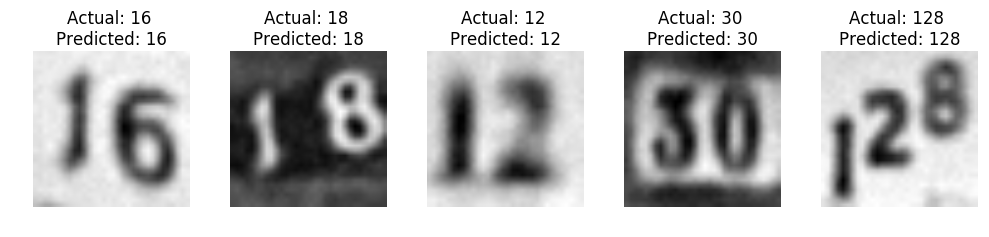

Wrong predicted length: 248 out of 13068


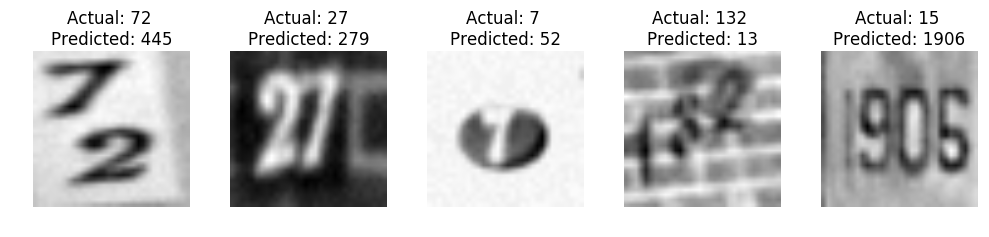

In [23]:
correct_length_indices=np.argwhere(digit_predictions_digit_model[:,0]==y_digit_test[:,0])
correct_length_indices=correct_length_indices.reshape(correct_length_indices.shape[0])

wrong_length_indices=np.argwhere(digit_predictions_digit_model[:,0]!=y_digit_test[:,0])
wrong_length_indices=wrong_length_indices.reshape(wrong_length_indices.shape[0])

print('Correct predicted length: %s out of %s'%(correct_length_indices.shape[0],y_digit_test.shape[0]))
display_result(correct_length_indices)
print('Wrong predicted length: %s out of %s'%(wrong_length_indices.shape[0],y_digit_test.shape[0]))
display_result(wrong_length_indices)

In [24]:
test_length_1 = np.sum(y_digit_test[:,0]==0)
test_length_2 = np.sum(y_digit_test[:,0]==1)
test_length_3 = np.sum(y_digit_test[:,0]==2)
test_length_4 = np.sum(y_digit_test[:,0]==3)
test_length_5 = np.sum(y_digit_test[:,0]==4)

In [25]:
correct_indices=np.argwhere(np.sum(digit_predictions_digit_model==y_digit_test,axis=1)==6)
correct_indices=correct_indices.reshape(correct_indices.shape[0])
wrong_indices=np.argwhere(np.sum(digit_predictions_digit_model==y_digit_test,axis=1)!=6)
wrong_indices=wrong_indices.reshape(wrong_indices.shape[0])

correct_predictions=digit_predictions_digit_model[correct_indices,:]
correct_predictions_labels=y_digit_test[correct_indices,:]
wrong_predictions=digit_predictions_digit_model[wrong_indices,:]
wrong_predictions_labels=y_digit_test[wrong_indices,:]

Correct result - length 1: 2337 out of 2483


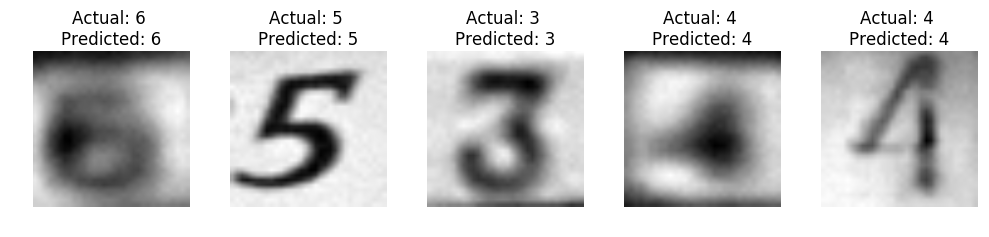

Wrong result - length 1: 146 out of 2483


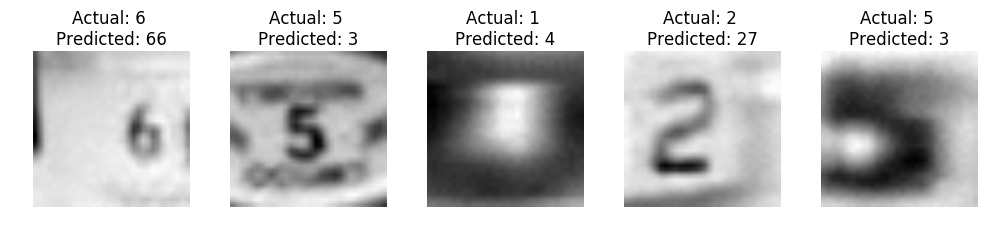

In [26]:
correct_len_1 = np.argwhere(correct_predictions_labels[:,0]==0)
correct_len_1 = correct_len_1.reshape(correct_len_1.shape[0])
correct_len_1_indices=correct_indices[correct_len_1]

wrong_len_1 = np.argwhere(wrong_predictions_labels[:,0]==0)
wrong_len_1 = wrong_len_1.reshape(wrong_len_1.shape[0])
wrong_len_1_indices=wrong_indices[wrong_len_1]

print('Correct result - length 1: %s out of %s'%(correct_len_1_indices.shape[0], test_length_1))
display_result(correct_len_1_indices)

print('Wrong result - length 1: %s out of %s'%(wrong_len_1_indices.shape[0], test_length_1))
display_result(wrong_len_1_indices)

Correct result - length 2: 7707 out of 8356


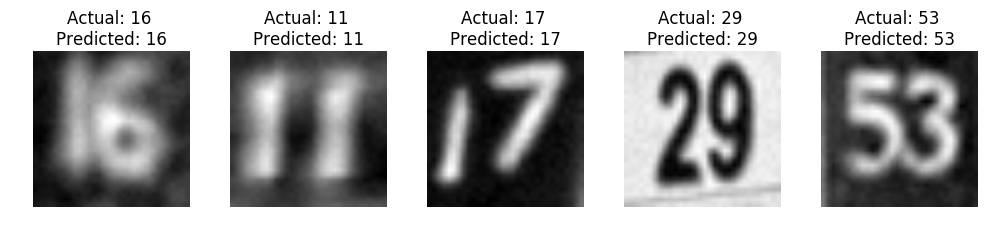

Wrong result - length 2: 649 out of 8356


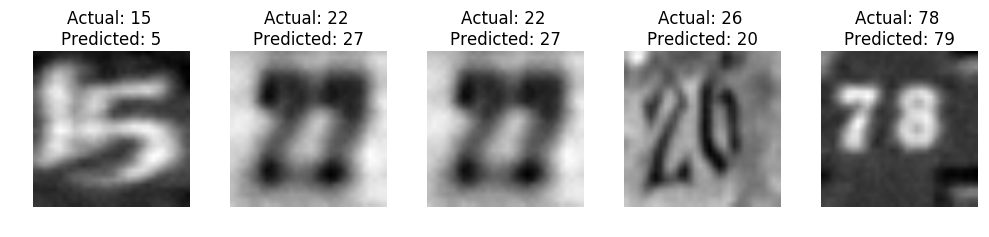

In [27]:
correct_len_2 = np.argwhere(correct_predictions_labels[:,0]==1)
correct_len_2 = correct_len_2.reshape(correct_len_2.shape[0])
correct_len_2_indices=correct_indices[correct_len_2]

wrong_len_2 = np.argwhere(wrong_predictions_labels[:,0]==1)
wrong_len_2 = wrong_len_2.reshape(wrong_len_2.shape[0])
wrong_len_2_indices=wrong_indices[wrong_len_2]

print('Correct result - length 2: %s out of %s'%(correct_len_2_indices.shape[0], test_length_2))
display_result(correct_len_2_indices)

print('Wrong result - length 2: %s out of %s'%(wrong_len_2_indices.shape[0], test_length_2))
display_result(wrong_len_2_indices)

Correct result - length 3: 1847 out of 2081


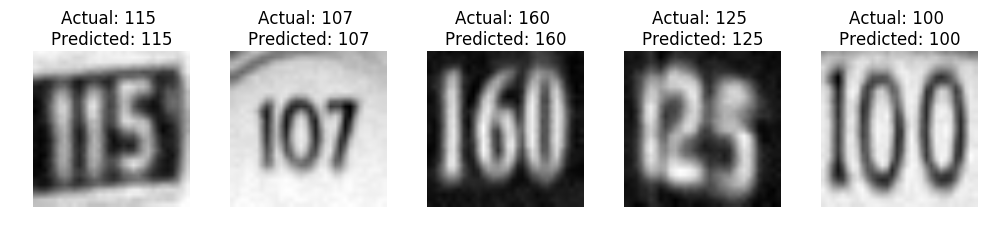

Wrong result - length 3: 234 out of 2081


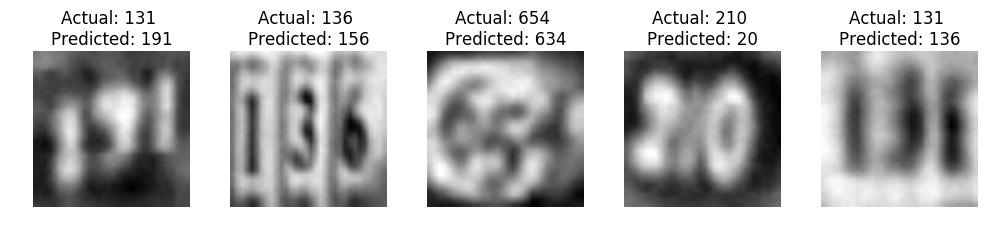

In [28]:
correct_len_3 = np.argwhere(correct_predictions_labels[:,0]==2)
correct_len_3 = correct_len_3.reshape(correct_len_3.shape[0])
correct_len_3_indices=correct_indices[correct_len_3]

wrong_len_3 = np.argwhere(wrong_predictions_labels[:,0]==2)
wrong_len_3 = wrong_len_3.reshape(wrong_len_3.shape[0])
wrong_len_3_indices=wrong_indices[wrong_len_3]

print('Correct result - length 3: %s out of %s'%(correct_len_3_indices.shape[0], test_length_3))
display_result(correct_len_3_indices)

print('Wrong result - length 3: %s out of %s'%(wrong_len_3_indices.shape[0], test_length_3))
display_result(wrong_len_3_indices)

Correct result - length 4: 129 out of 146


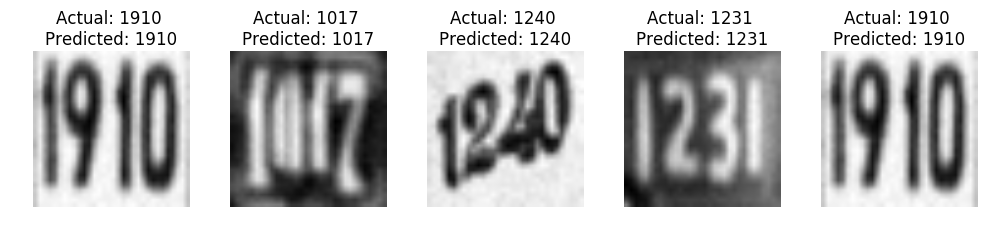

Wrong result - length 4: 17 out of 146


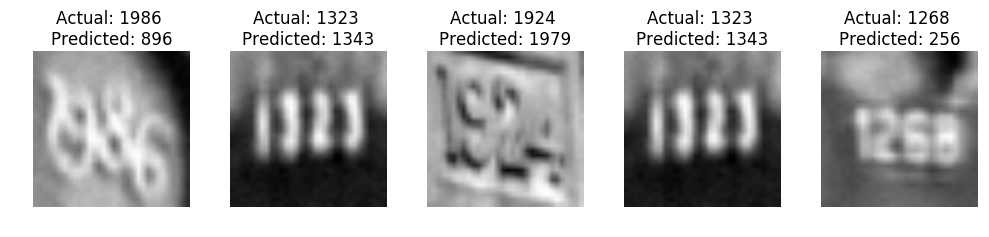

In [29]:
correct_len_4 = np.argwhere(correct_predictions_labels[:,0]==3)
correct_len_4 = correct_len_4.reshape(correct_len_4.shape[0])
correct_len_4_indices=correct_indices[correct_len_4]

wrong_len_4 = np.argwhere(wrong_predictions_labels[:,0]==3)
wrong_len_4 = wrong_len_4.reshape(wrong_len_4.shape[0])
wrong_len_4_indices=wrong_indices[wrong_len_4]

print('Correct result - length 4: %s out of %s'%(correct_len_4_indices.shape[0], test_length_4))
display_result(correct_len_4_indices)

print('Wrong result - length 4: %s out of %s'%(wrong_len_4_indices.shape[0], test_length_4))
display_result(wrong_len_4_indices)

Correct result - length 5: 0 out of 2
Wrong result - length 5: 2 out of 2


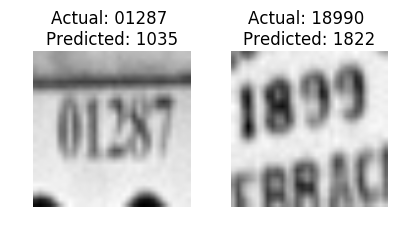

In [30]:
correct_len_5 = np.argwhere(correct_predictions_labels[:,0]==4)
correct_len_5 = correct_len_5.reshape(correct_len_5.shape[0])
correct_len_5_indices=correct_indices[correct_len_5]

wrong_len_5 = np.argwhere(wrong_predictions_labels[:,0]==4)
wrong_len_5 = wrong_len_5.reshape(wrong_len_5.shape[0])
wrong_len_5_indices=wrong_indices[wrong_len_5]

print('Correct result - length 5: %s out of %s'%(correct_len_5_indices.shape[0], test_length_5))
display_result(correct_len_5_indices)

print('Wrong result - length 5: %s out of %s'%(wrong_len_5_indices.shape[0], test_length_5))
display_result(wrong_len_5_indices)

### Visualize bounding box prediction results

In [31]:
def display_result_bbox(indices):
    if (len(indices)>0):
        fig = plt.figure(figsize=(10, 6))
    rows = 1
    columns = 5
    for i in range(rows*columns):
        if (i<len(indices)):
            index = np.random.choice(indices)
            actual_label=get_string_label(y_digit_test[index,:])
            predicted_label=get_string_label(digit_predictions_digit_model[index,:].astype(np.int32))

            img = X_test[index,:,:,0]
            ax = fig.add_subplot(rows, columns, i+1)
            plt.title('Actual: %s \nPredicted: %s'%(actual_label,predicted_label))
            plt.axis("off")
            plt.imshow(img,cmap='gray')
            
            top=y_bbox_test[index,0:5]
            left=y_bbox_test[index,5:10]
            width=y_bbox_test[index,10:15]
            height=y_bbox_test[index,15:20]
            
            top_predict=bbox_predictions_bbox_model[index,1:6]
            left_predict=bbox_predictions_bbox_model[index,6:11]
            width_predict=bbox_predictions_bbox_model[index,11:16]
            height_predict=bbox_predictions_bbox_model[index,16:21]
            
            for j in range(int(bbox_predictions_bbox_model[index,0])+1):
                b_actual = Rectangle((left[j], top[j]),
                              width[j],
                              height[j],
                              fill=False,
                              color='blue')   
                ax.add_patch(b_actual)
                
                score = batch_iou(np.concatenate((left[j].reshape(1,1),
                                                  top[j].reshape(1,1),
                                                  (left[j]+width[j]-1).reshape(1,1),
                                                  (top[j]+height[j]-1).reshape(1,1)),
                                                 axis=1), 
                                  np.concatenate((left_predict[j].reshape(1,1),
                                                  top_predict[j].reshape(1,1),
                                                  (left_predict[j]+width_predict[j]-1).reshape(1,1),
                                                  (top_predict[j]+height_predict[j]-1).reshape(1,1)),
                                                 axis=1))
                if(score>0.7):
                    color='green'
                else:
                    color='red'
                b_predict = Rectangle((left_predict[j], top_predict[j]),
                              width_predict[j],
                              height_predict[j],
                              fill=False,
                              color=color)   
                ax.add_patch(b_predict)
            
    if (len(indices)>0):
        plt.tight_layout()
        plt.show()

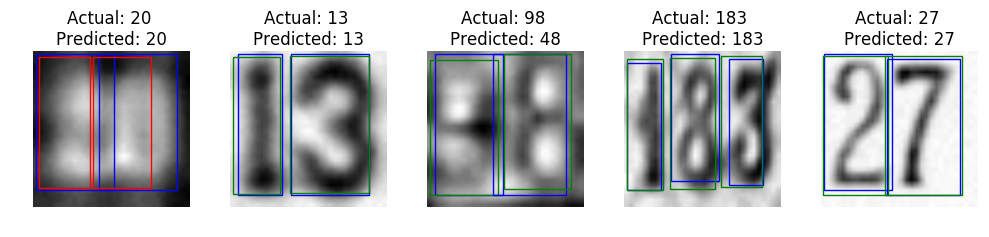

In [32]:
display_result_bbox(range(bbox_predictions_bbox_model.shape[0]))